# <span style="font-weight:bold"> Step 3: Data Processing </span>
---
---

**Data processing** plays a critical role in enhancing model performance, particularly for algorithms that are sensitive to feature scales, outliers, and distribution shapes.

For our case, the data processing workflow for the **training dataset** involves the following key steps:

1. Address outliers and correct skewed feature distributions  
2. Apply encoding for categorical variables (if applicable)  
3. Standardize numerical features through feature scaling  


In [1]:
# Imports and environment setup
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create required folders if they don't exist
os.makedirs("../data", exist_ok=True)

# Load our dataset
df_train = pd.read_csv("../data/cleaned_train.csv")

# Make a copy of the training data for processing
df_train_copy = df_train.copy()

### Visulisation Metrics

In [2]:
# LOADING CUSTOM FUNCTIONS
def visualize_univariate_feature(df, col):
    """
    Visualize a feature using histogram and boxplot,
    and print skewness and number of outliers.
    """
    data = df[col].dropna()

    # Calculate skewness
    sk = skew(data)

    # Calculate number of outliers using IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(data, bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Histogram")
    
    sns.boxplot(x=data, ax=axes[1], color='lightcoral')
    axes[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

    # Stats
    print(f"Skewness of `{col}`: {sk:.2f}")
    print(f"Number of outliers: {outliers}")

def visualize_scaling_effect(df):
    """
    Plots the distribution of continuous features before and after StandardScaler scaling.
    Automatically excludes 'Status', 'Year', and 'TARGET_LifeExpectancy'.
    """
    exclude_cols = ['Status', 'Year', 'TARGET_LifeExpectancy']
    columns = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)

    for col in columns:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Original: {col}")

        plt.subplot(1, 2, 2)
        sns.histplot(scaled_data[col], kde=True, bins=30)
        plt.title(f"Scaled: {col}")

        plt.tight_layout()
        plt.show()


def visualize_before_after_winsorization_with_stats(df, col):
    """
    Visualize histogram and boxplot before and after winsorization.
    Print skewness and outlier count for both cases.
    """
    data = df[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    capped = data.clip(lower=lower, upper=upper)

    outliers_before = ((data < lower) | (data > upper)).sum()
    outliers_after = ((capped < lower) | (capped > upper)).sum()

    skew_before = skew(data)
    skew_after = skew(capped)

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f"{col} — Before vs After Winsorization", fontsize=14, fontweight='bold')

    sns.histplot(data, bins=30, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title("Before - Histogram")

    sns.boxplot(x=data, ax=axes[1, 0], color='lightcoral')
    axes[1, 0].set_title("Before - Boxplot")

    sns.histplot(capped, bins=30, kde=True, ax=axes[0, 1], color='mediumseagreen')
    axes[0, 1].set_title("After - Histogram")

    sns.boxplot(x=capped, ax=axes[1, 1], color='salmon')
    axes[1, 1].set_title("After - Boxplot")

    plt.tight_layout()
    plt.show()

    print(f"=== {col} Using Winsorization ===")
    print(f"Skewness before: {skew_before:.2f}")
    print(f"Skewness after: {skew_after:.2f}")
    print(f"Outliers before: {outliers_before}")
    print(f"Outliers after: {outliers_after}")



def visualize_log_and_capping_stats(df, col):
    """
    Visualize histogram and boxplot before and after log transform.
    Print skewness and outlier count for both cases.
    """
    data = df[col].dropna()
    log_data = np.log(data)

    def count_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        return ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()

    original_skew = skew(data)
    log_skew = skew(log_data)
    original_outliers = count_outliers(data)
    log_outliers = count_outliers(log_data)

    fig, axes = plt.subplots(2, 2, figsize=(14, 6))
    fig.suptitle(f"{col} — Before vs After Log Transform", fontsize=14, fontweight='bold')
    sns.histplot(data, bins=30, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title(f'{col} - Histogram (Original)')
    sns.histplot(log_data, bins=30, kde=True, ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title(f'{col} - Histogram (Log Transformed)')
    sns.boxplot(x=data, ax=axes[1, 0], color='salmon')
    axes[1, 0].set_title(f'{col} - Boxplot (Original)')
    sns.boxplot(x=log_data, ax=axes[1, 1], color='lightcoral')
    axes[1, 1].set_title(f'{col} - Boxplot (Log Transformed)')
    plt.tight_layout()
    plt.show()

  
    print(f"=== {col} Using Log Transformation ===")
    print(f"Skewness before: {original_skew:.2f}")
    print(f"Skewness after log: {log_skew:.2f}")
    print(f"Outliers before: {original_outliers}")
    print(f"Outliers after log: {log_outliers}")

In [3]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET_LifeExpectancy         2071 non-null   float64
 1   Year                          2071 non-null   int64  
 2   Status                        2071 non-null   int64  
 3   AdultMortality                2071 non-null   float64
 4   Alcohol                       2071 non-null   float64
 5   BMI                           2071 non-null   float64
 6   Under5LS                      2071 non-null   float64
 7   Polio                         2071 non-null   float64
 8   TotalExpenditure              2071 non-null   float64
 9   Diphtheria                    2071 non-null   float64
 10  HIV-AIDS                      2071 non-null   float64
 11  GDP                           2071 non-null   float64
 12  Population                    2071 non-null   float64
 13  Thi

,TARGET_LifeExpectancy,Year,Status,AdultMortality,Alcohol,BMI,Under5LS,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,IncomeCompositionOfResources,Schooling
count,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2.071000e+03,2071.000000,2071.000000,2071.000000
mean,69.274505,2009.518590,0.185418,162.820290,4.691323,37.590439,45.829068,82.725736,5.880659,82.753259,1.630324,7278.635879,1.200826e+07,4.938194,0.609976,3.372593
std,9.482281,4.614147,0.388730,118.870557,4.201380,19.909768,185.249715,23.188101,2.551218,23.130969,4.781878,15151.000344,6.391757e+07,4.696869,0.216360,0.589992
min,37.300000,2002.000000,0.000000,1.000000,0.010000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.880000,3.400000e+01,0.100000,0.000000,0.000000
25%,63.000000,2006.000000,0.000000,74.000000,0.620000,18.800000,0.000000,77.000000,4.200000,78.000000,0.100000,413.730000,1.274450e+05,1.600000,0.463000,3.065942
50%,71.200000,2010.000000,0.000000,144.000000,3.820000,42.100000,4.000000,93.000000,5.640000,93.000000,0.100000,1390.315000,6.477440e+05,3.200000,0.655500,3.449638
75%,76.000000,2014.000000,0.000000,228.000000,7.840000,55.900000,27.000000,97.000000,7.430000,97.000000,0.800000,5648.115000,5.349200e+06,7.350000,0.769500,3.741657
max,92.700000,2017.000000,1.000000,699.000000,17.870000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,133473.470000,1.293859e+09,27.700000,0.948000,4.381780


## <span style="font-weight:bold"> 1. Handle Outliers </span>
To prepare the data for modeling, especially for algorithms that are sensitive to skewed distributions and extreme values, I handled each numeric feature individually. I used **capping (manual winsorization)**, **log transformation**, and **Yeo-Johnson transformation** depending on the shape and range of each feature.

To guide our outlier handling strategy, we re-evaluate the number and proportion of extreme values in each skewed feature using the IQR method, based on the cleaned dataset. This ensures consistency between our preprocessing plan and the latest version of the data.

> NOTES: For **Alcohol** and **BMI** columns, these columns had very low skew and no outliers, so transformation is not needed here so I just scaled it afterward.

#### <span style="font-style:italic"> 1.1 Right-skewed Data </span>


In [4]:
# Define right-skewed features
right_skewed_features = [
    'Population', 'GDP', 'HIV-AIDS', 'AdultMortality',
    'TotalExpenditure', 'Schooling', 'Alcohol'
]

# Function to count outliers using IQR
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers

# Analyze outliers
outlier_results = []
n = len(df_train_copy)

for col in right_skewed_features:
    outliers = count_outliers_iqr(df_train_copy[col])
    percentage = (outliers / n) * 100
    outlier_results.append({
        'Feature': col,
        'Outliers': outliers,
        'Outlier %': round(percentage, 2)
    })

# Display
outlier_df = pd.DataFrame(outlier_results).sort_values(by='Outliers', ascending=False)
print(outlier_df.to_string(index=False))


         Feature  Outliers  Outlier %
        HIV-AIDS       365      17.62
             GDP       301      14.53
      Population       286      13.81
  AdultMortality        42       2.03
       Schooling        40       1.93
TotalExpenditure        33       1.59
         Alcohol         0       0.00


#### <span> **Schooling & TotalExpenditure** </span>


> I applied mild capping to deal with a few unusually high values but didn’t apply any transformation since the distribution was otherwise acceptable.

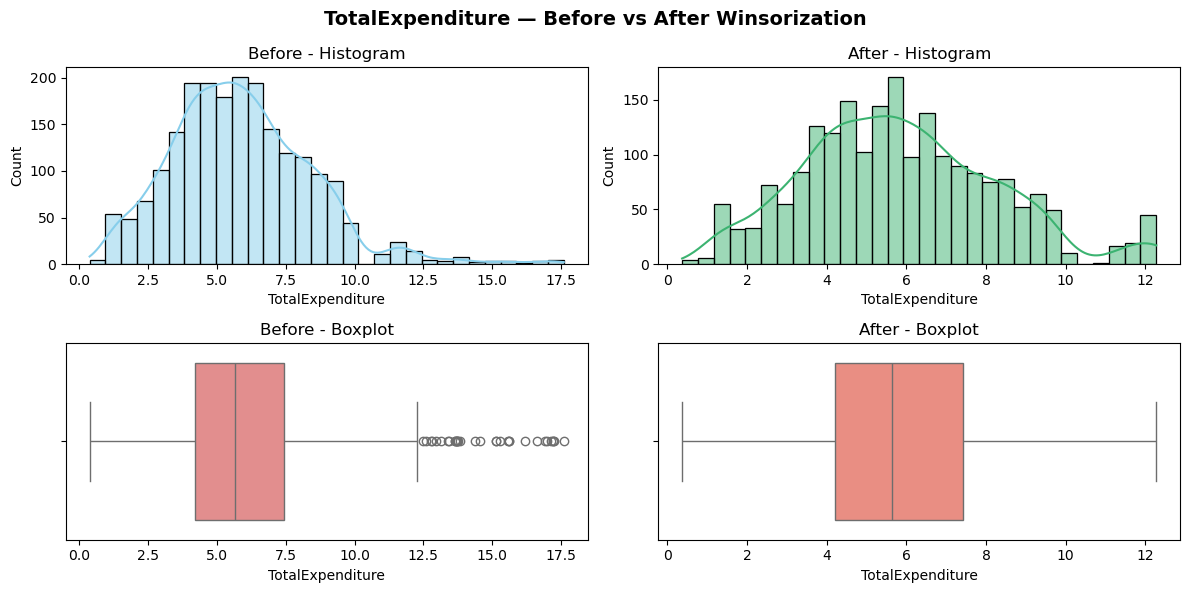

=== TotalExpenditure Using Winsorization ===
Skewness before: 0.80
Skewness after: 0.41
Outliers before: 33
Outliers after: 0


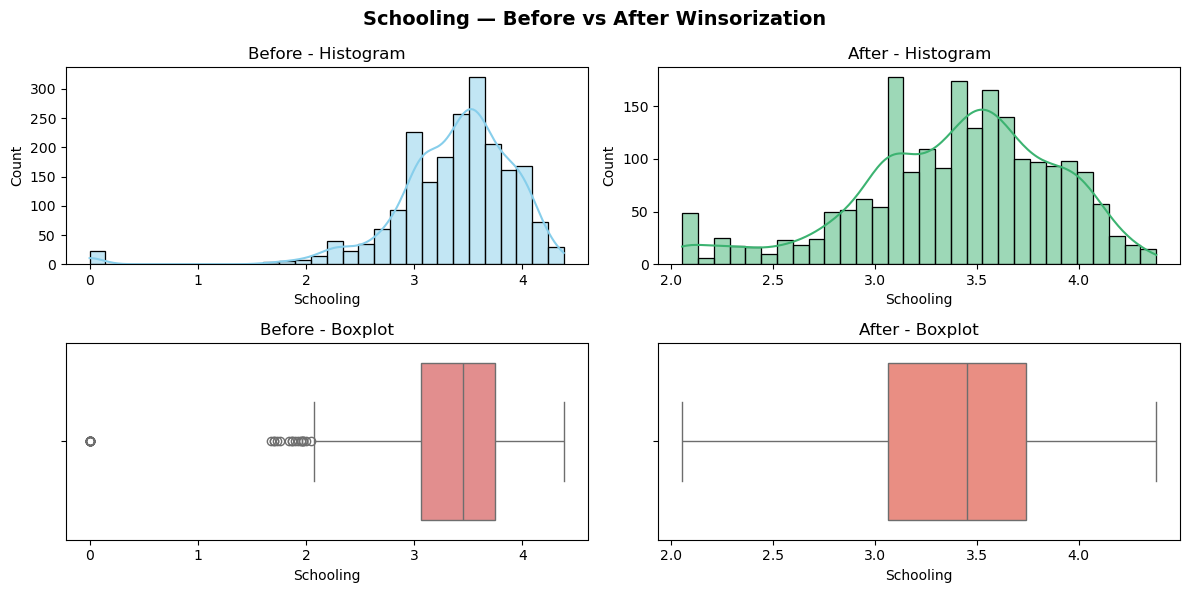

=== Schooling Using Winsorization ===
Skewness before: -2.27
Skewness after: -0.64
Outliers before: 40
Outliers after: 0


In [5]:
visualize_before_after_winsorization_with_stats(df_train_copy, 'TotalExpenditure')
visualize_before_after_winsorization_with_stats(df_train_copy, 'Schooling')

#### <span> **Thinness1-19years** </span>
> This was right-skewed and included 0s, making Yeo-Johnson the best option to reduce distortion while keeping the data intact.


=== Thinness1-19years ===

 BEFORE YEOJOHNSON TRANSFORMATION


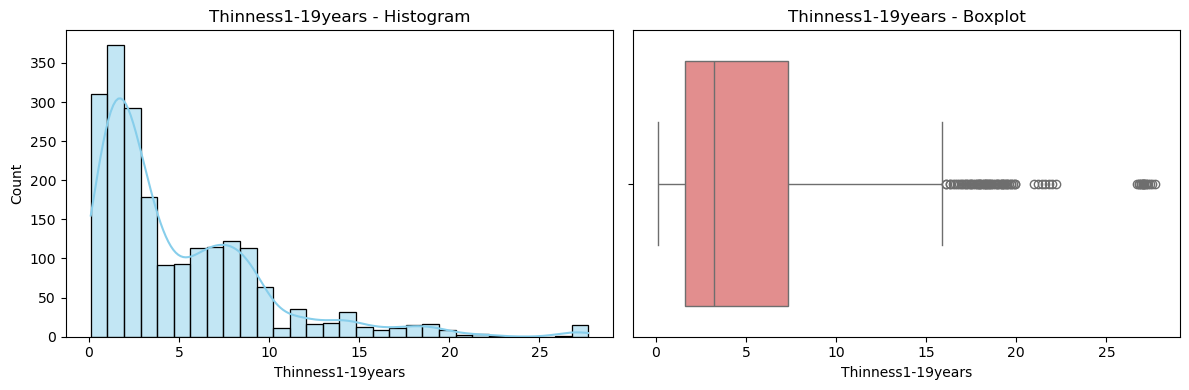

Skewness of `Thinness1-19years`: 1.80
Number of outliers: 79

 AFTER YEOJOHNSON TRANSFORMATION


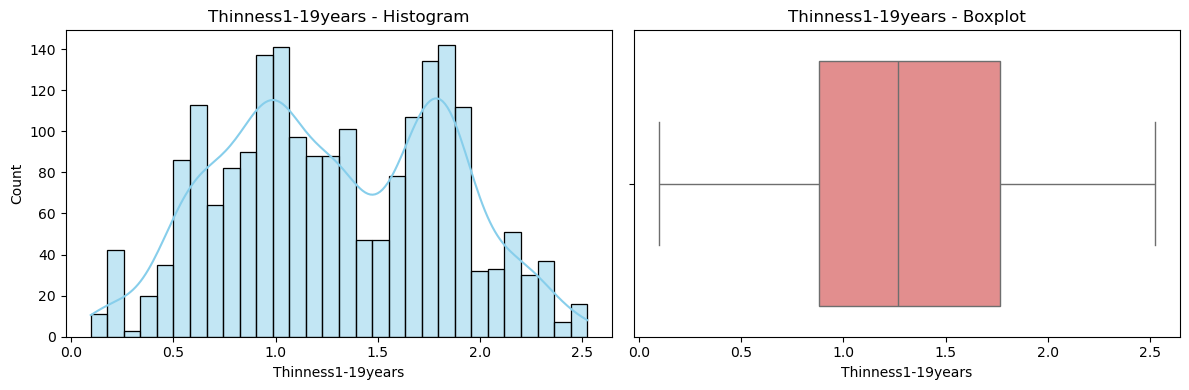

Skewness of `Thinness1-19years`: 0.04
Number of outliers: 0


In [6]:
print("\n=== Thinness1-19years ===")
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Thinness1-19years')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['Thinness1-19years'] = pt.fit_transform(df_train_copy[['Thinness1-19years']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Thinness1-19years')

#### <span> **Under5LS** </span>


> This feature had a long right tail and some 0 values, so I used Yeo-Johnson to normalize it safely without removing the 0s.


=== Under5LS ===

 BEFORE YEOJOHNSON TRANSFORMATION


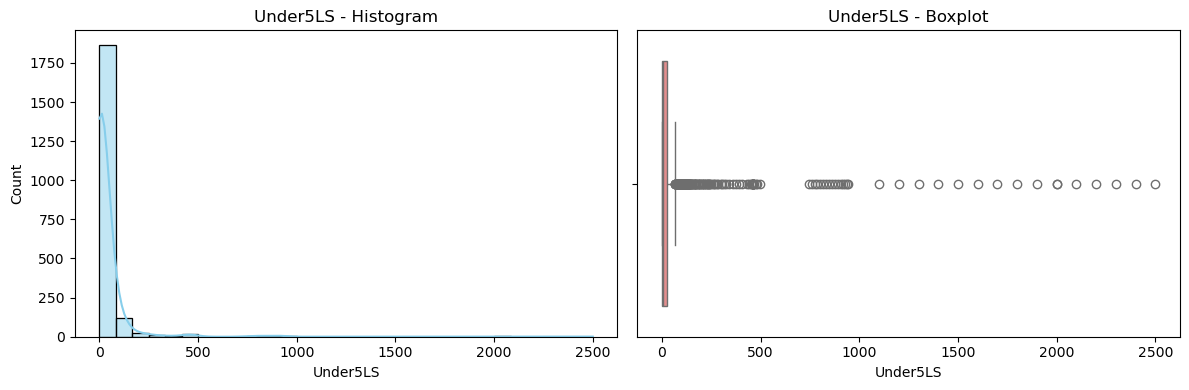

Skewness of `Under5LS`: 8.60
Number of outliers: 240

 AFTER YEOJOHNSON TRANSFORMATION


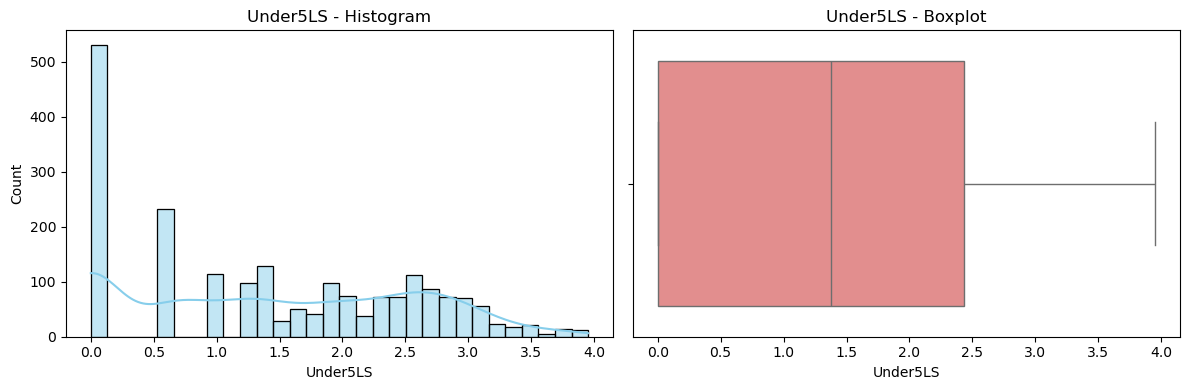

Skewness of `Under5LS`: 0.15
Number of outliers: 0


In [7]:
print("\n=== Under5LS ===")
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Under5LS')

pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['Under5LS'] = pt.fit_transform(df_train_copy[['Under5LS']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Under5LS')


#### <span> **HIV-AIDS** </span>
> This feature has long tails and were highly skewed. I used **Yeo-Johnson transformation** to normalize it for better fit in linear models.


=== HIV-AIDS ===

 BEFORE YEOJOHNSON TRANSFORMATION


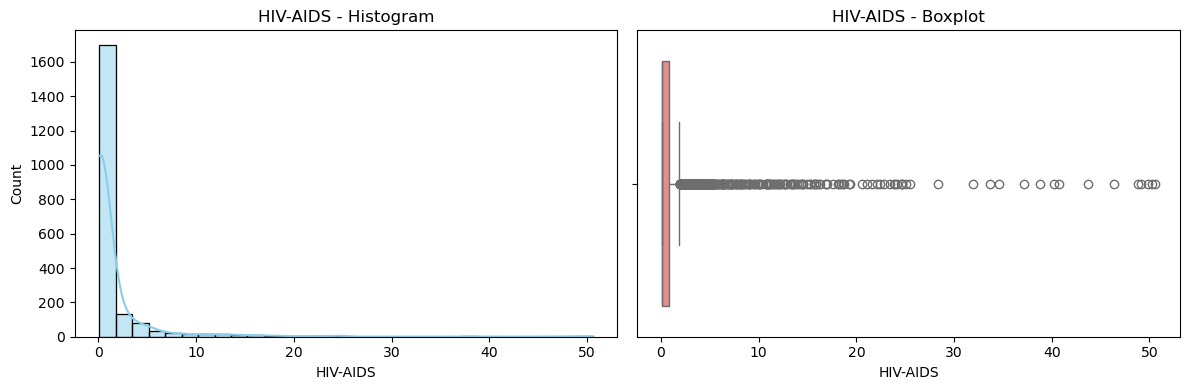

Skewness of `HIV-AIDS`: 5.92
Number of outliers: 365

 AFTER YEOJOHNSON TRANSFORMATION


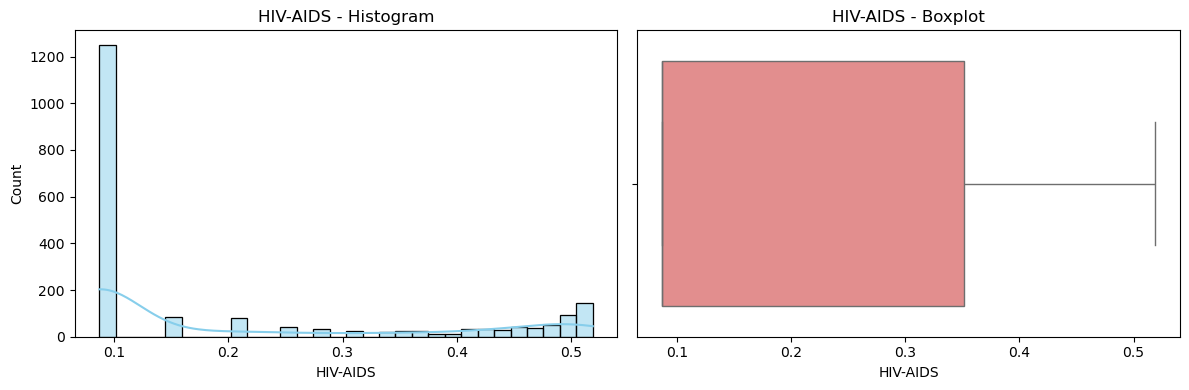

Skewness of `HIV-AIDS`: 0.94
Number of outliers: 0


In [8]:
print("\n=== HIV-AIDS ===")
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'HIV-AIDS')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['HIV-AIDS'] = pt.fit_transform(df_train_copy[['HIV-AIDS']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'HIV-AIDS')

#### <span> **AdultMortality** </span>


> Also right-skewed, with large variance. Yeo-Johnson was a good fit here to stabilize variance and reduce the pull of extreme values.


=== AdultMortality ===

 BEFORE YEOJOHNSON TRANSFORMATION


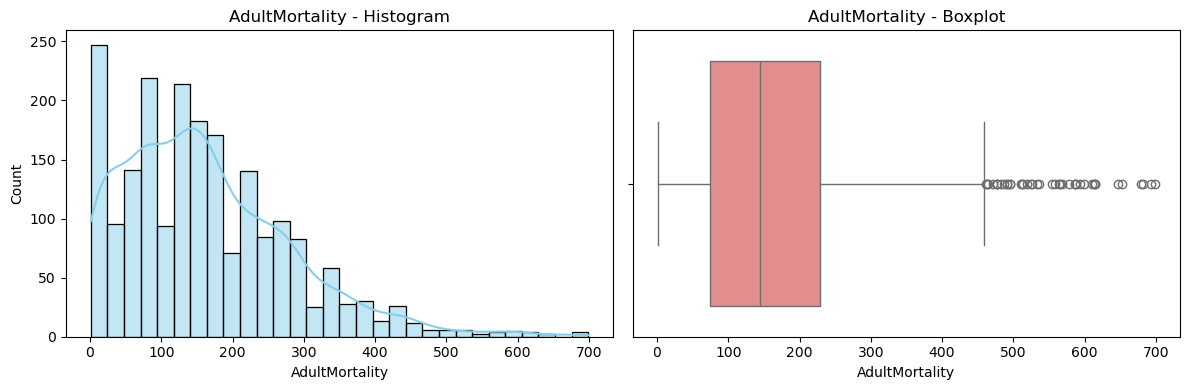

Skewness of `AdultMortality`: 1.06
Number of outliers: 42

 AFTER YEOJOHNSON TRANSFORMATION


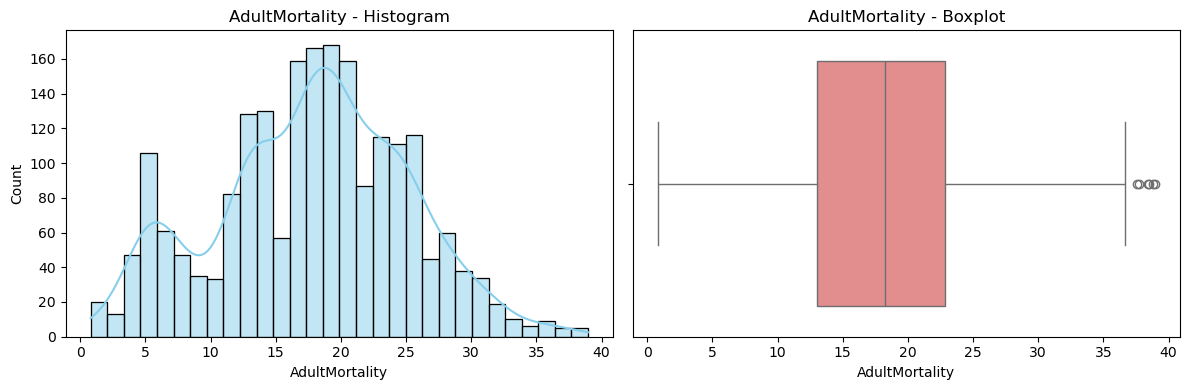

Skewness of `AdultMortality`: -0.09
Number of outliers: 6


In [9]:
print("\n=== AdultMortality ===")
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'AdultMortality')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['AdultMortality'] = pt.fit_transform(df_train_copy[['AdultMortality']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'AdultMortality')

#### <span> **GDP** </span>
> I applied a Yeo-Johnson transformation because the distribution was heavily right-skewed, and this method can handle small values and reduce skew without requiring a log.


=== GDP ===

 BEFORE YEOJOHNSON TRANSFORMATION


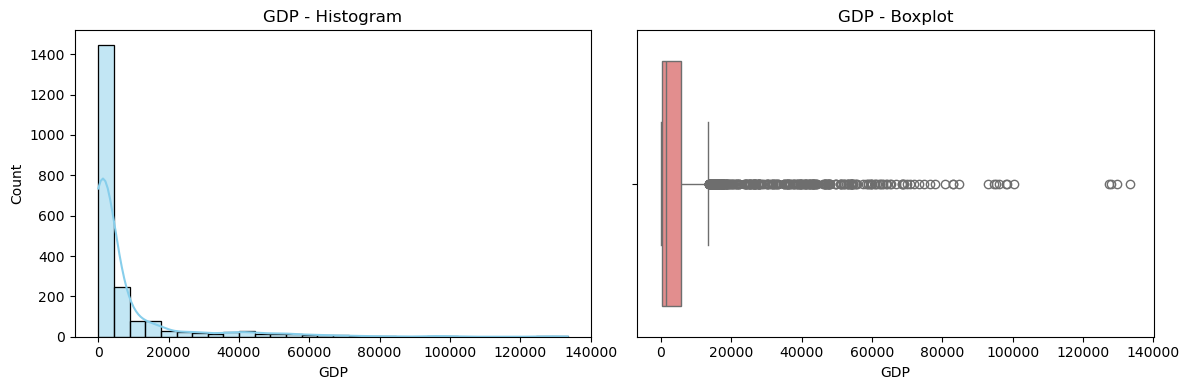

Skewness of `GDP`: 3.61
Number of outliers: 301

 AFTER YEOJOHNSON TRANSFORMATION


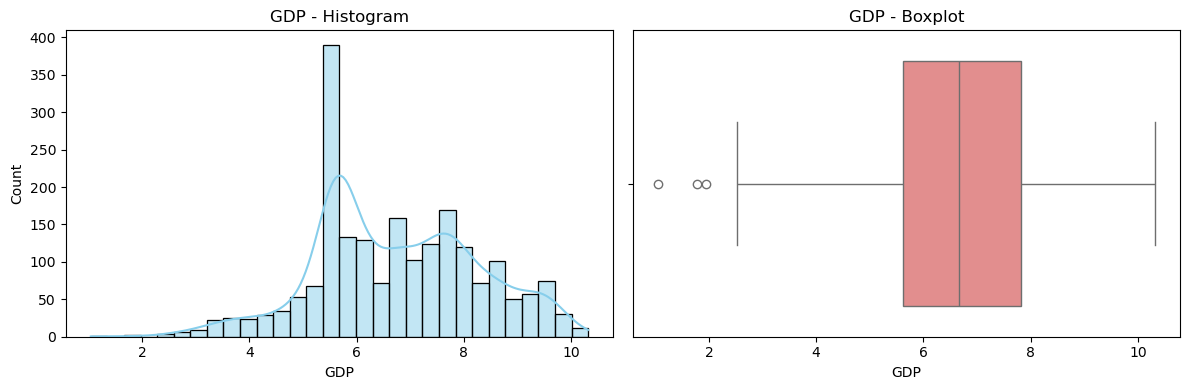

Skewness of `GDP`: 0.00
Number of outliers: 3


In [10]:
print("\n=== GDP ===")
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'GDP')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['GDP'] = pt.fit_transform(df_train_copy[['GDP']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'GDP')

#### <span> **Population** </span>


> It was extremely right-skewed with values ranging in the billions. A log transformation was the most appropriate way to compress these large values and improve symmetry.

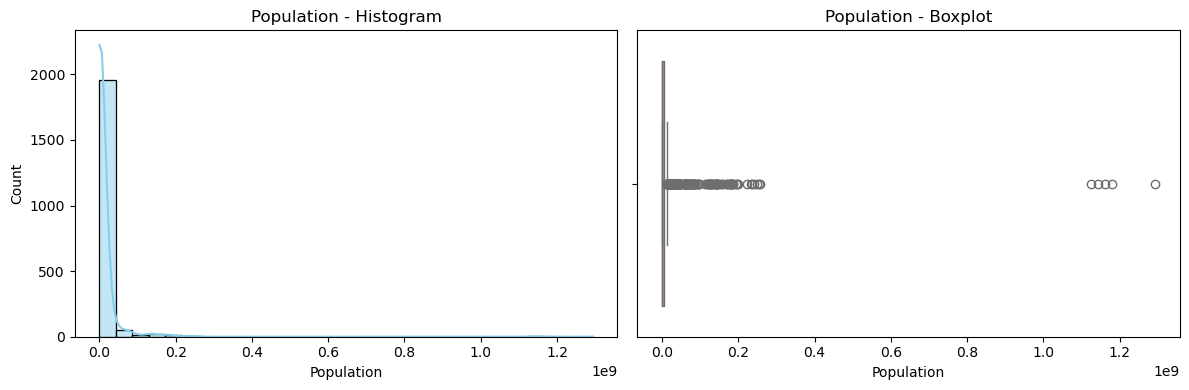

Skewness of `Population`: 15.30
Number of outliers: 286


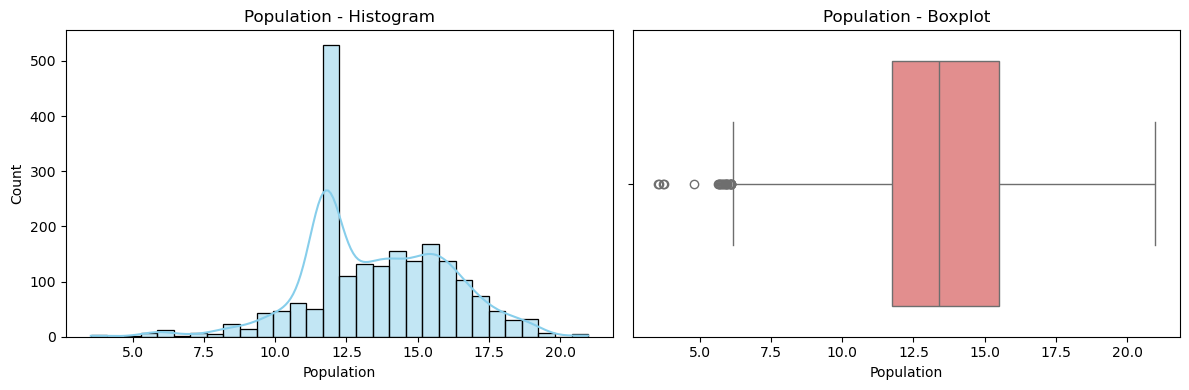

Skewness of `Population`: -0.13
Number of outliers: 24


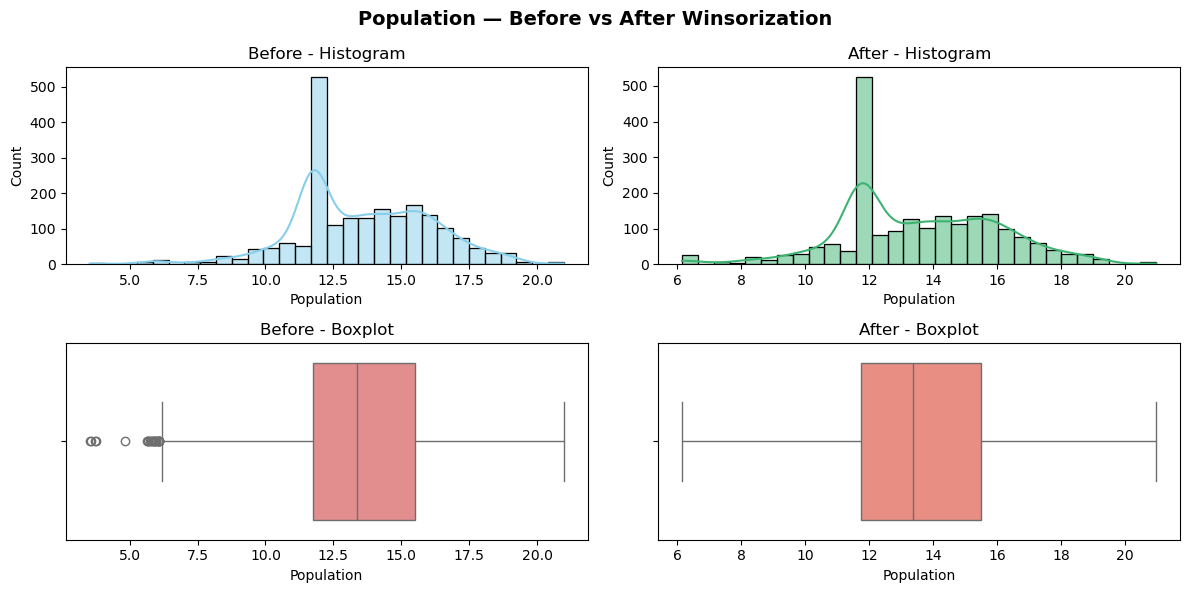

=== Population Using Winsorization ===
Skewness before: -0.13
Skewness after: -0.04
Outliers before: 24
Outliers after: 0


In [11]:
visualize_univariate_feature(df_train_copy, 'Population')
df_train_copy['Population'] = np.log(df_train_copy['Population'])
visualize_univariate_feature(df_train_copy, 'Population')
visualize_before_after_winsorization_with_stats(df_train_copy, 'Population')

#### <span style="font-style:italic"> 1.2 Left-skewed Data </span>


Let's check how many outliers and skewness that we have here.

In [12]:
# Define right-skewed features
left_skewed_features = [
    'Polio', 'Diphtheria','IncomeCompositionOfResources'
]
# Analyze outliers
outlier_results_left = []
n = len(df_train_copy)

for col in left_skewed_features:
    outliers = count_outliers_iqr(df_train_copy[col])
    percentage = (outliers / n) * 100
    outlier_results_left.append({
        'Feature': col,
        'Outliers': outliers,
        'Outlier %': round(percentage, 2)
    })

# Display
outlier_df = pd.DataFrame(outlier_results_left).sort_values(by='Outliers', ascending=False)
print(outlier_df.to_string(index=False))


                     Feature  Outliers  Outlier %
                  Diphtheria       206       9.95
                       Polio       183       8.84
IncomeCompositionOfResources       108       5.21


#### <span> **Polio** </span>


> Since many values were clustered near 100, I capped the extreme highs and then applied Yeo-Johnson to improve the left-skewed distribution while preserving the feature's meaning.


=== Polio ===

 BEFORE YEOJOHNSON TRANSFORMATION


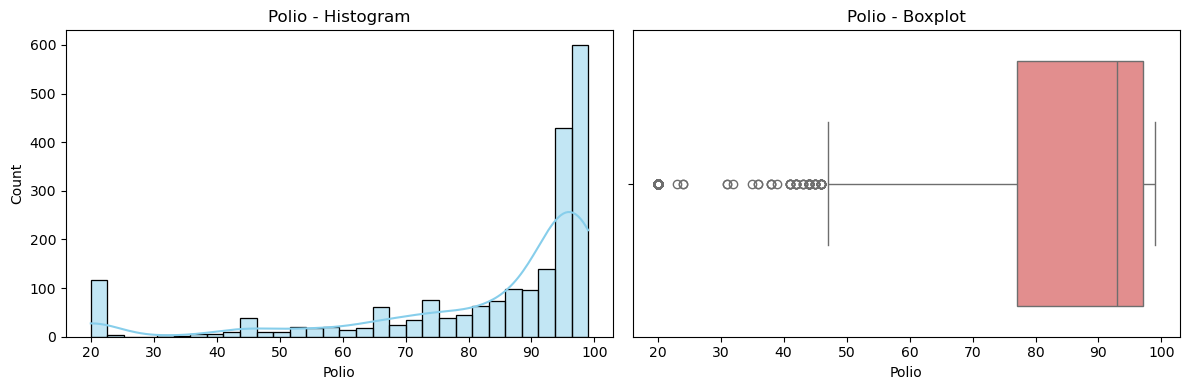

Skewness of `Polio`: -1.82
Number of outliers: 183

 AFTER YEOJOHNSON TRANSFORMATION


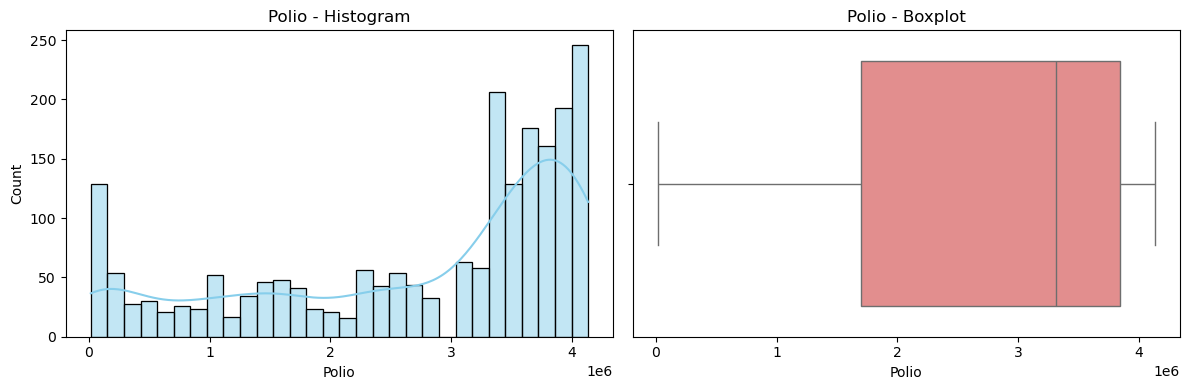

Skewness of `Polio`: -0.82
Number of outliers: 0


In [13]:
print("\n=== Polio ===")
df_train_copy['Polio'] = df_train_copy['Polio'].clip(lower=20)
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Polio')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['Polio'] = pt.fit_transform(df_train_copy[['Polio']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Polio')


#### <span> **Diphtheria** </span>


> I used the same strategy as for Polio — first capping the upper end, then applying Yeo-Johnson to address the slight left skew.


=== Diphtheria ===

 BEFORE YEOJOHNSON TRANSFORMATION


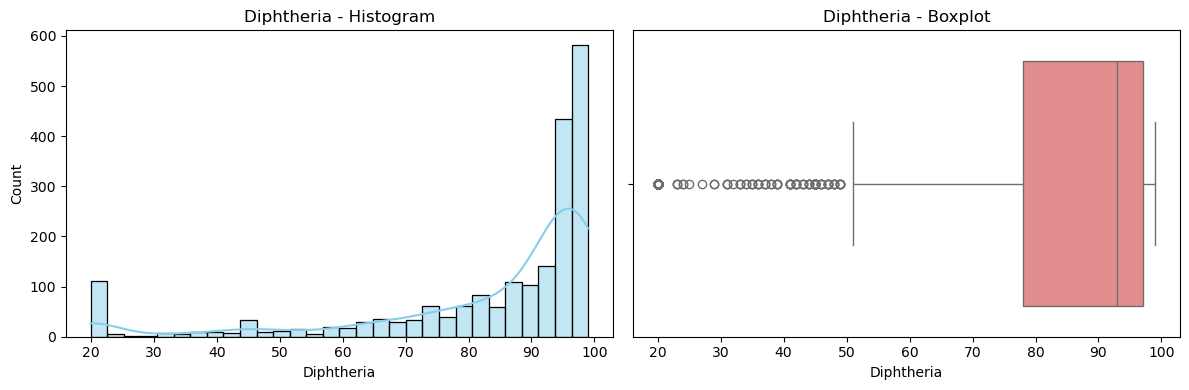

Skewness of `Diphtheria`: -1.84
Number of outliers: 206

 AFTER YEOJOHNSON TRANSFORMATION


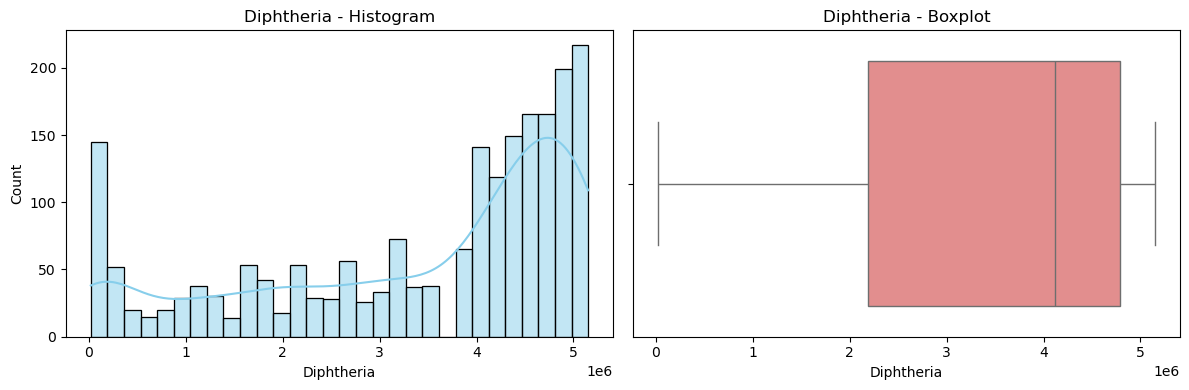

Skewness of `Diphtheria`: -0.83
Number of outliers: 0


In [14]:
print("\n=== Diphtheria ===")
# Clip minimum diphtheria to 20
df_train_copy['Diphtheria'] = df_train_copy['Diphtheria'].clip(lower=20)

print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Diphtheria')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['Diphtheria'] = pt.fit_transform(df_train_copy[['Diphtheria']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'Diphtheria')

#### <span> **IncomeCompositionOfResources** </span>


> This feature was slightly left-skewed and bounded between 0 and 1. I used Yeo-Johnson to gently normalize the distribution without altering the scale.


 BEFORE YEOJOHNSON TRANSFORMATION


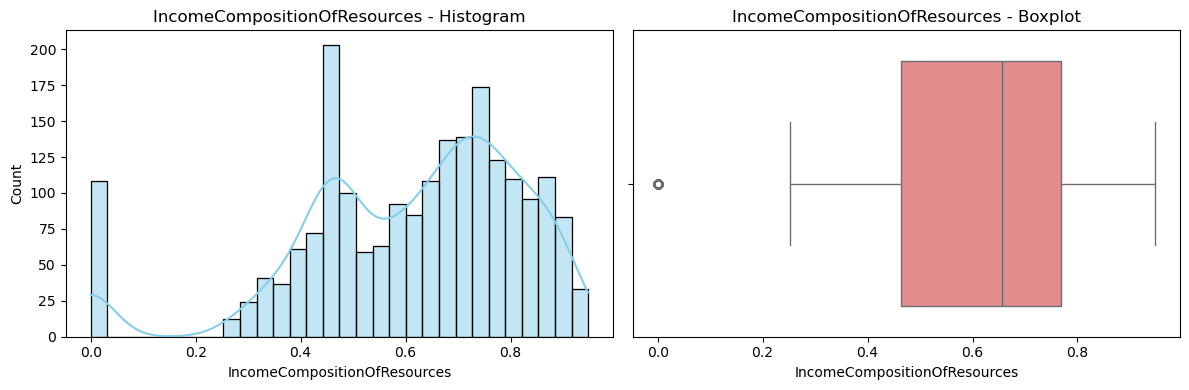

Skewness of `IncomeCompositionOfResources`: -1.00
Number of outliers: 108

 AFTER YEOJOHNSON TRANSFORMATION


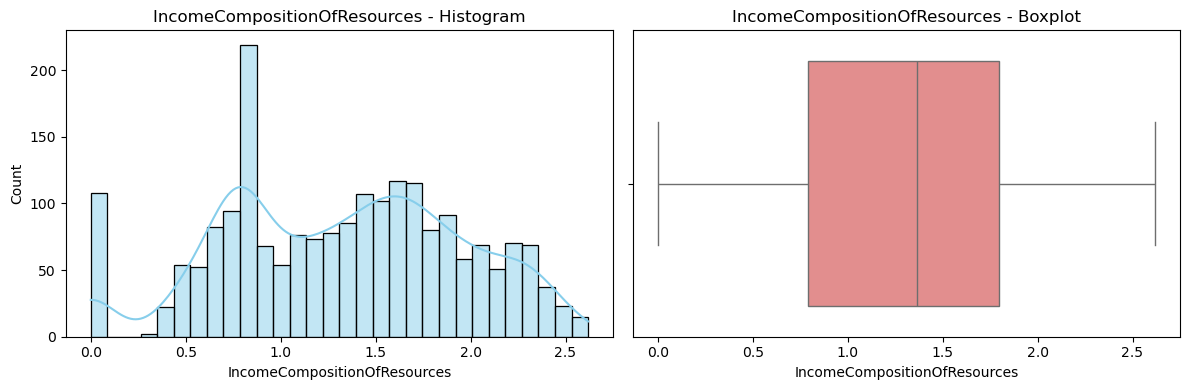

Skewness of `IncomeCompositionOfResources`: -0.13
Number of outliers: 0


In [15]:
print("\n BEFORE YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'IncomeCompositionOfResources')
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_train_copy['IncomeCompositionOfResources'] = pt.fit_transform(df_train_copy[['IncomeCompositionOfResources']])
print("\n AFTER YEOJOHNSON TRANSFORMATION")
visualize_univariate_feature(df_train_copy, 'IncomeCompositionOfResources')

## <span style="font-weight:bold"> 2. Scaling</span>


After finishing outlier handling and fixing skew, I scaled all continuous features using **StandardScaler**, which standardizes the data to have mean 0 and standard deviation 1. This is important for models like linear regression, KNN, and SVM that are sensitive to feature scale.

I made sure to **exclude** the following from scaling:
- `Status`: this is already encoded as 0/1, so scaling doesn’t make sense for it.
- `Year`: it’s an ordinal time index, so I chose to keep it in its original form.
- `TARGET_LifeExpectancy`: this is the target variable and doesn’t need to be scaled in my case.

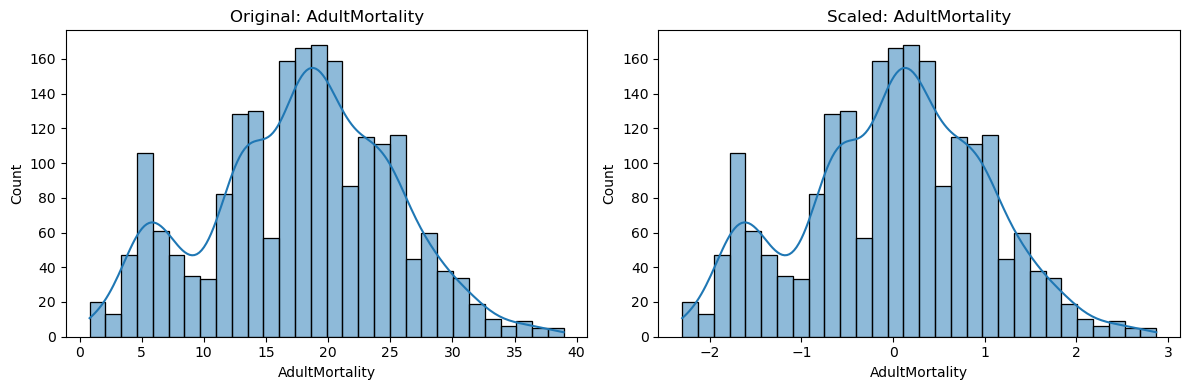

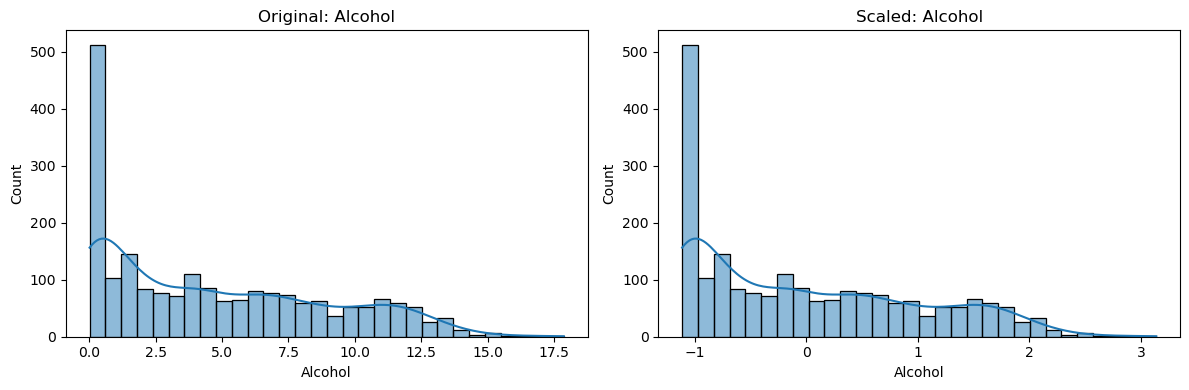

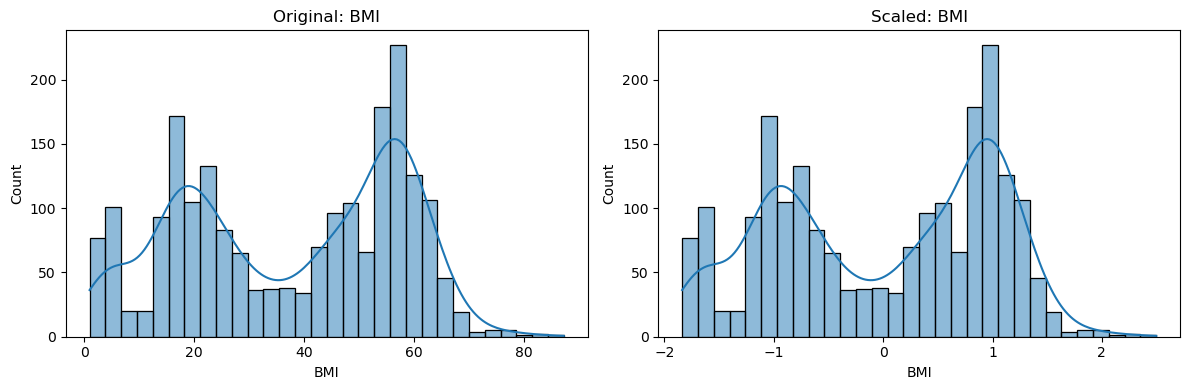

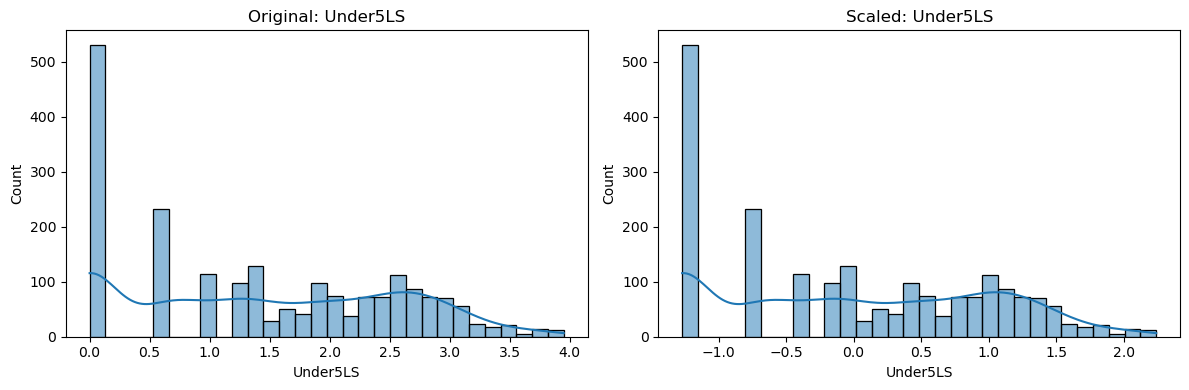

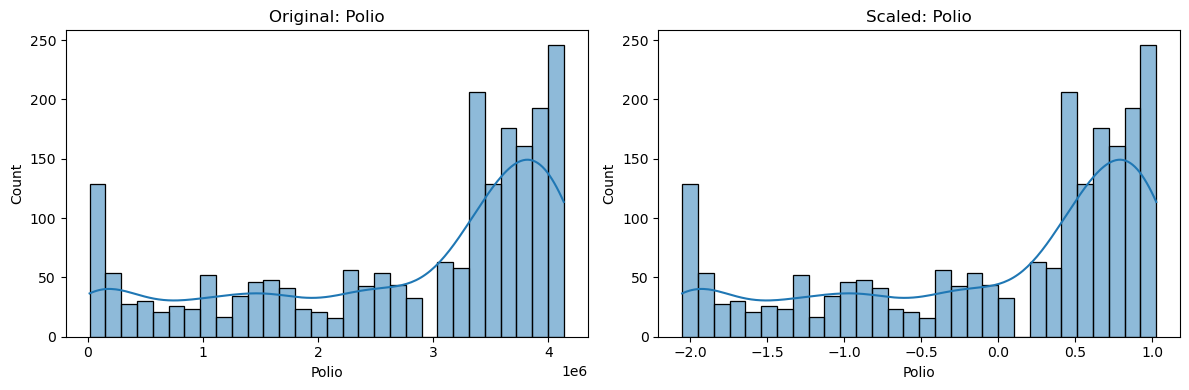

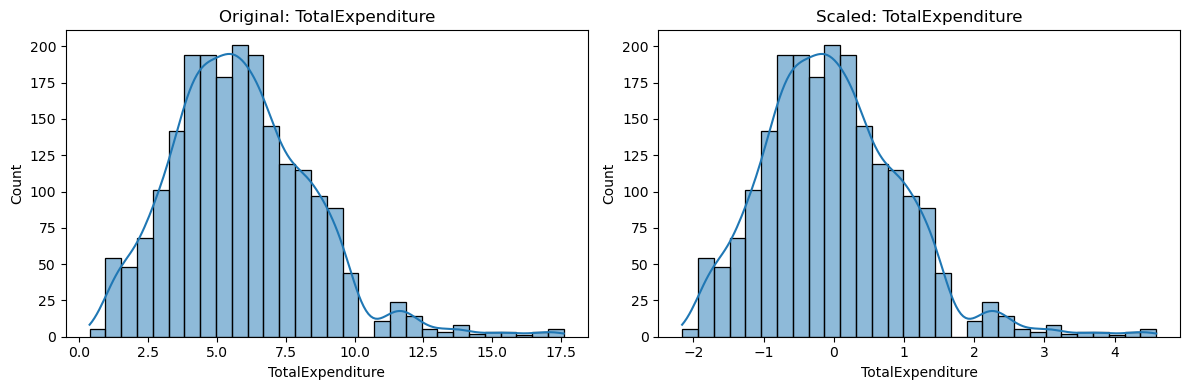

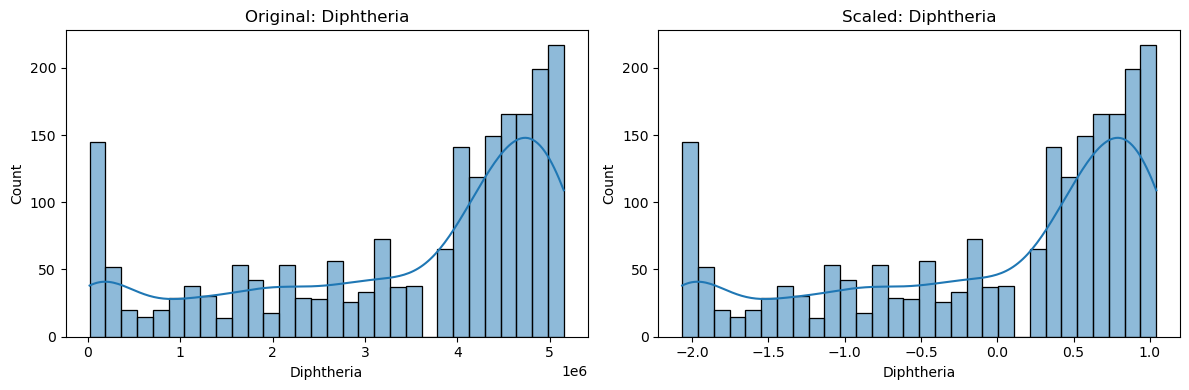

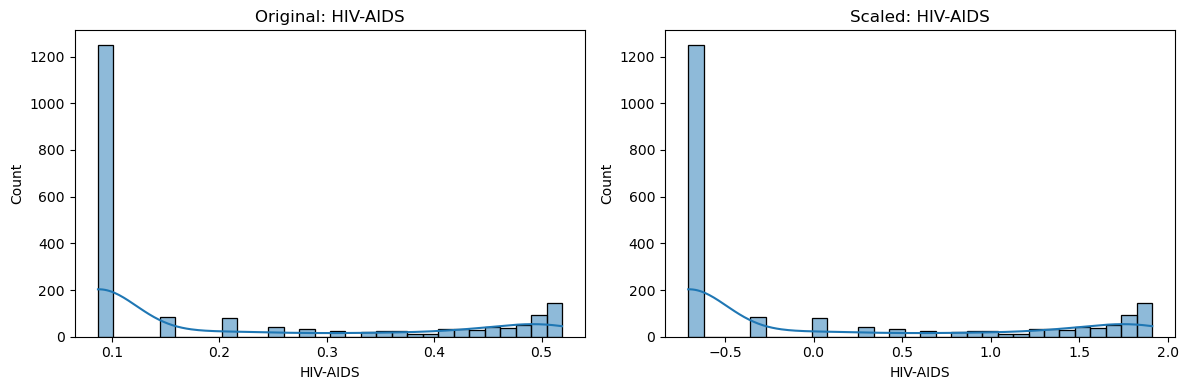

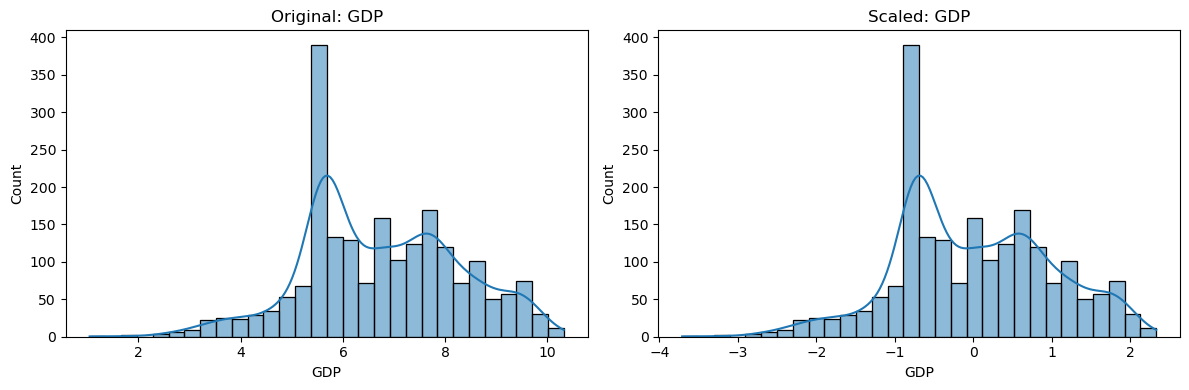

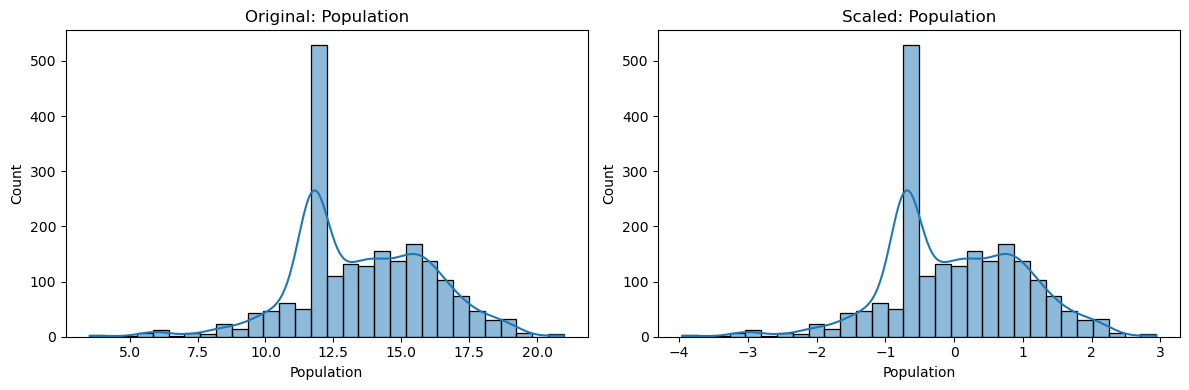

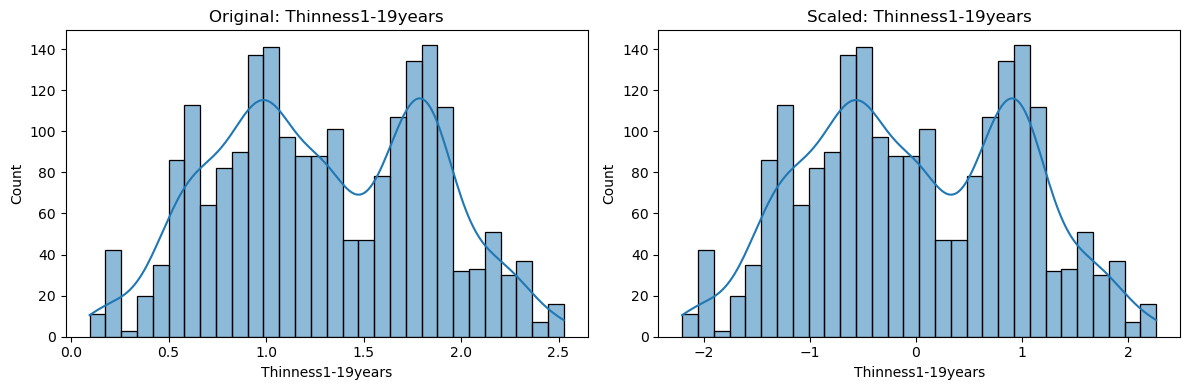

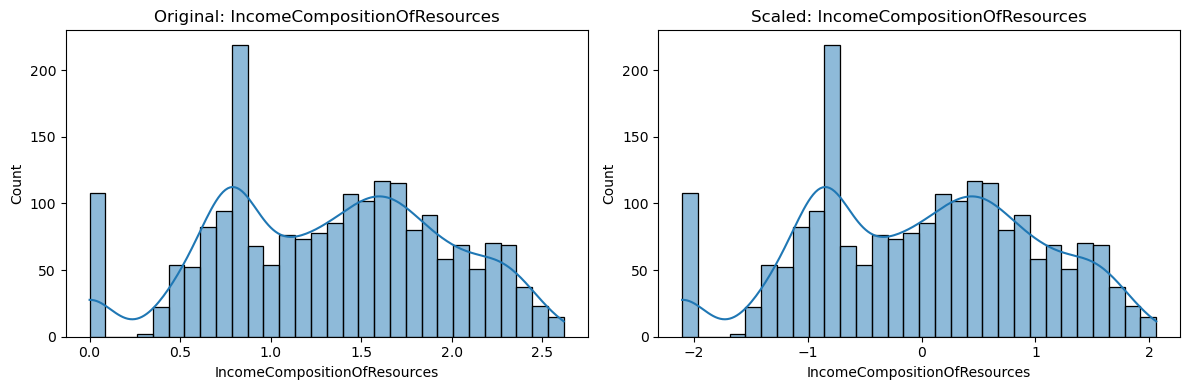

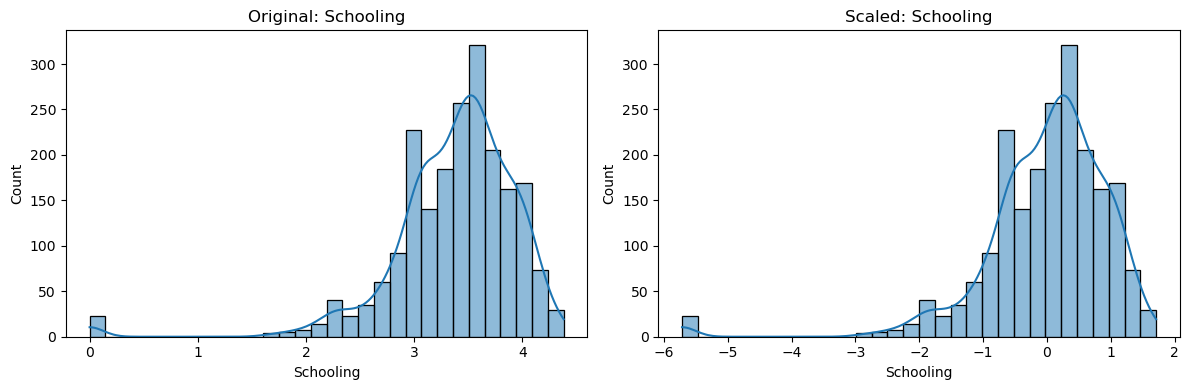

In [16]:
# Already excluded "Status", "Year" and "TARGET_LifeExpectancy" from the scaling function
visualize_scaling_effect(df_train_copy)

In [17]:
# Save the final processed training data to CSV
df_train_copy.to_csv("../data/processed_train.csv", index=False)
print("Processed dataset saved as 'processed_train.csv'")

Processed dataset saved as 'processed_train.csv'
